# Linear Regression the Hard Way

Task: fit a linear regression using gradient descent

## Setup

In [2]:
import numpy as np
np.set_printoptions(precision=3)
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Task

Suppose we have a dataset with just a single feature `x` and continuous outcome variable `y`. We'll have a few possible datasets.

In [35]:
DATASET = 'toy'

if DATASET == 'toy':
    x = np.array([0, 1, 2, 3])[:, np.newaxis]
    y_true = np.array([-1, .5, 2.0, 3.5])[:, np.newaxis]
elif DATASET == "temps":
    data = pd.read_csv("https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/Global_Mean_Estimates_based_on_Land_and_Ocean_Data/graph.csv", skiprows=1)
    # Shape x to be items-by-features
    x = data.iloc[:, 0].values.astype(np.float32)[:, np.newaxis]
    # scale x to a reasonable range
    x -= 1880.0
    x /= 100.
    y_true = data.iloc[:, 1].values.astype(np.float32)[:, np.newaxis]


(4, 1) (4, 1)


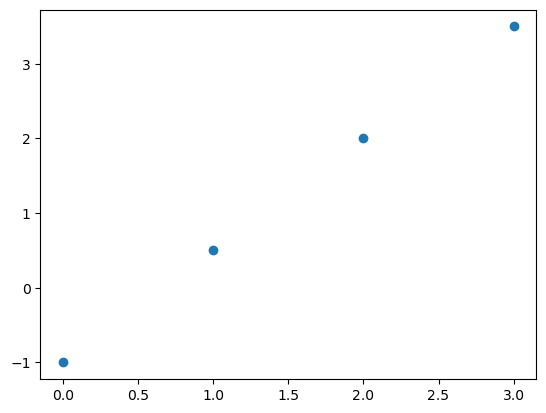

In [36]:
if len(x) < 50:
    plt.scatter(x, y_true)
else:
    plt.plot(x, y_true)
print(x.shape, y_true.shape)

Create some features that we'll need later; don't worry about this code right now.

In [37]:
# a simple hardcoded linear layer
pretend_first_layer_out = x @ np.ones((1, 2)) + np.array([0.0, -0.5])
# a rectifier
pretend_first_layer_activations = np.maximum(pretend_first_layer_out, 0.0)
f1, f2 = pretend_first_layer_activations.T

This notebook will be a bit different from usual: you'll be editing a *single* block of code. So the final notebook won't show your intermediate steps. That doesn't mean they aren't important; make sure you successfully complete each step before moving on to the next one.

iteration 0, loss 1.750, weights [0.15], bias 0.050
iteration 10, loss 0.537, weights [1.], bias 0.025
iteration 20, loss 0.338, weights [1.2], bias -0.375
iteration 30, loss 0.150, weights [1.45], bias -0.725
iteration 40, loss 0.175, weights [1.55], bias -0.925
Final Loss: 0.150, final weights: [1.4], final bias: [-1.025]


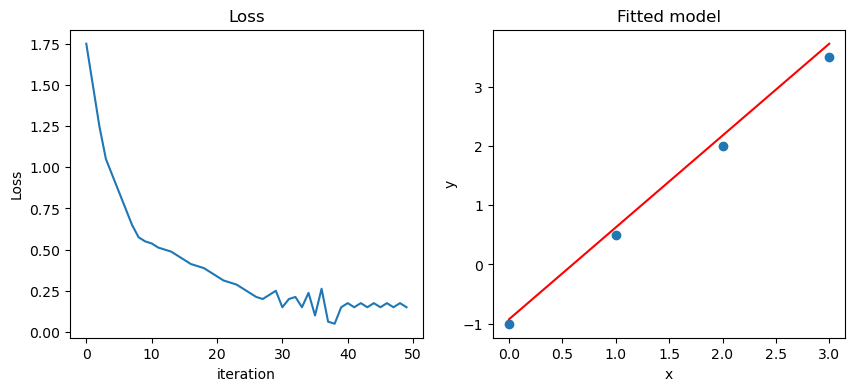

In [38]:
## Working Cell

# Set hyperparameters
learning_rate = 0.1
num_iter = 50

# Initialize parameters
weights = np.array([[0.0]])
bias = np.array([0.0])

# Keep a log of loss values
losses = []

# Repeat for each iteration
for i in range(num_iter):
    # Forward pass
    # 1. compute predictions
    # In Step 1, this is just doing y_pred = x * weights because `bias` will always be 0.
    y_pred = x @ weights + bias
    # 2. Compute loss
    resid = ...
    loss = ...
    losses.append(loss)

    # Backward pass: compute gradients
    n_points = x.shape[0]
    y_pred_grad = -1.0 * np.sign(resid) / n_points
    weights_grad = x.T @ y_pred_grad
    bias_grad = y_pred_grad.sum()
    
    # Descend the gradient.
    weights -= learning_rate * weights_grad
    bias -= learning_rate * bias_grad
    
    # Print some information
    if i % 10 == 0:
        print(f"iteration {i}, loss {loss.item():.3f}, weights {weights.flatten()}, bias {bias.item():.3f}")
    
# Plot the results
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(losses)
axs[0].set(title="Loss", xlabel="iteration", ylabel="Loss")
axs[1].scatter(x, y_true)
axs[1].plot(x, y_pred, 'r');
axs[1].set(title="Fitted model", xlabel='x', ylabel='y')
print(f"Final Loss: {losses[-1]:.3f}, final weights: {weights.flatten()}, final bias: {bias}")

### Step 1: Slope Only, MSE

Fill in the blanks in the code above so that it fits the model `y_pred = weights * x` to the data `x` and `y_true` in a way that minimizes the mean squared error (MSE).

Note that there is no intercept, so y_pred is 0.0 when x is 0.0.

Terminology:

- *weights*: the slope of the line
- *loss*: the mean squared error.

You should achieve a loss between 0.09 and 0.11.

In [8]:
# don't write new code here; edit the code block above.

### Step 2: Slope and intercept (aka weight and bias)

The model currently has a single parameter, `weights`. Now, incorporate another parameter into the model, `bias`. The new parameter should have the same shape as the output (in this case, a single number). The prediction equation will now be `y_pred = weights * x + bias`. Use the same data and loss function.

Terms:

- *bias*: the intercept of the line

You can initialize `bias` to 0 just like `weights`. (In general you'd use a random number, but this problem is well-behaved so zero will work.)

You should get an MSE of between 0.03 and 0.035.

**Note**: Make sure that you descend the gradient of the bias, and also that you *zero this gradient* each time, just like we do for the weights. You probably need to *increase the number of iterations* or tune the learning rate.

### Step 3: Change the loss function

Now, minimize the Mean Absolute Error (mean of abs(resid)) instead of the MSE. Use the same model `y_pred = weights * x + bias` and data.

You should get an MAE of around 0.15.

## Step 4: Multiple linear regression

Note that the data seems to have different slopes in different parts. Ideally, rather than fitting a single line, we should fit a model where the slopes can change.

We can actually do this using linear regression in the same way as we did before. We can think of linear regression as mixing together some functions. In Steps 2 and 3 we mixed together two functions: an "always going up" function for x and a flat function, i.e., $f_1(x) = x$ and $f_2(x) = 1.0$.

Let's add another function into the mix. The easiest way to describe it is to see it:

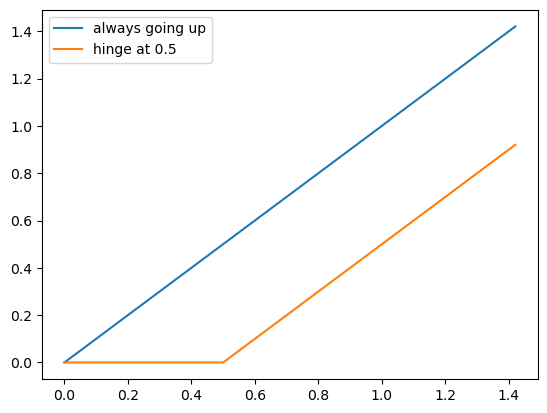

In [11]:
plt.plot(x, f1, label="always going up")
plt.plot(x, f2, label="hinge at 0.5")
plt.legend();

Why might that help us? Well, we can mix them together. Try adjusting the mixing weights to fit the data.

In [12]:
r = 2.0
@widgets.interact(w1=(-r, r), w2=(-r, r), bias=(-1.0, 1.0))
def plot_linreg(w1=.1, w2=-.3, bias=0.0):
    y_pred = w1 * f1 + w2 * f2 + bias
    plt.scatter(x, y_true)
    plt.plot(x, y_pred, 'r')
    resid = y_true - y_pred
    mse = resid.pow(2).mean()
    mae = resid.abs().mean()
    print(f"MSE: {mse}, MAE: {mae}")

interactive(children=(FloatSlider(value=0.1, description='w1', max=2.0, min=-2.0), FloatSlider(value=-0.3, des…

Now, switch back to MSE, but edit your code block so that it fits the model `y_pred = w1 * f1 + w2 * f2 + bias`. Use MSE loss and the same data.


We've given you a suggestively-named `pretend_first_layer_activations` that has `f1` and `f2` as its two columns. So you can use that as the `x` for your model. First, study the following code block to see how the shapes work. **Try changing `torch.zeros(2, 1)` to `torch.zeros(1, 2)` and be able to explain the error you get.**

Once you understand that, adapt tho code block to use the `pretend_first_layer_activations`.
You should get an MSE between 0.01 and 0.03, i.e., significantly better than the first model.

In [13]:
example_weight_mat = torch.zeros(2, 1)
print("weight matrix:", example_weight_mat)
print("input has shape", pretend_first_layer_activations.shape)
print("example_weight_mat has shape", example_weight_mat.shape)
print("Matrix multiply has shape", (pretend_first_layer_activations @ example_weight_mat).shape)

weight matrix: tensor([[0.],
        [0.]])
input has shape torch.Size([143, 2])
example_weight_mat has shape torch.Size([2, 1])
Matrix multiply has shape torch.Size([143, 1])
